#### Part 3 - Optional
The business also wants you to do a PoC to see if they can predict `loan_amnt` based on the following features (feel free to use additional ones if you would like): `emp_length`,`home_ownership`, `annual_inc`.
Build a brand new regression model, `reg_model`, leveraging `LinearRegression` from `sklearn.linear_model` 

In [8]:
python_material_folder_name = "python-material"

In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, make_scorer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

In [10]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif5.csv")
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,term_numeric,debt_to_income,loan_amnt_log,grade_encoded,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,cashier,10+ years,MORTGAGE,48000.0,Source Verified,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,0.1308,36.0,0.083333,8.294300,1,-1.196895,-0.367206,0.083969,0.004364,False
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,ABM,6 years,RENT,57000.0,Source Verified,Feb-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,708xx,LA,25.33,0.0,Jan-2004,680.0,684.0,0.0,NaN,NaN,10.0,0.0,22697.0,64.5%,24.0,w,4333.29,4333.29,25496.160000,25496.16,19666.71,5829.45,0.0,0.0,0.0,May-2020,500.07,Jun-2020,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,61815.0,0.0,3.0,0.0,3.0,14.0,39118.0,72.0,1.0,1.0,2137.0,67.0,35200.0,0.0,7.0,0.0,4.0,6182

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Select features and target variable
features = ['emp_length', 'home_ownership', 'annual_inc']
target = 'loan_amnt'
X = df[features].copy()
y = df[target]

# Preprocess categorical variable `home_ownership` using OneHotEncoding
# Since emp_length might also be categorical, preprocess it similarly (if necessary)
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['home_ownership', 'emp_length'])
    ],
    remainder='passthrough'  # Keep other numeric features as they are
)

# Define a pipeline with preprocessing and regression model
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 84350362.61486816
R-squared (R2): 0.06608078114917504


## Explanation of steps:

**Data Selection:**

- We use emp_length, home_ownership, and annual_inc as the primary features. If needed, you can preprocess or encode other columns and include them as well.

**Preprocessing:**

- OneHotEncoder is used to handle categorical variables (home_ownership and potentially emp_length if it's non-numeric).

- The ColumnTransformer ensures that numeric features (e.g., annual_inc) remain unchanged while categorical features are encoded.

**Pipeline Setup:**

- A Pipeline simplifies preprocessing and model training by combining all steps into one workflow.

- The LinearRegression model is applied after preprocessing.

**Model Training:**

- The train_test_split function divides the data into training and testing sets.

- The model is trained using the training data and evaluated on the test data.

**Evaluation:**

- The Mean Squared Error (MSE) quantifies the average squared difference between predicted and actual values (lower is better).

- The R-squared (R2) score measures how well the model explains the variability in the data (higher is better, with 1.0 being perfect).

## Adding more features 

In [13]:
from sklearn.compose import ColumnTransformer  # Import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Required preprocessors
from sklearn.pipeline import Pipeline  # Pipeline for combining steps
from sklearn.linear_model import LinearRegression  # Regression model
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics
from sklearn.model_selection import train_test_split  # Train-test split

# Define features and target variable
features = ['home_ownership', 'emp_length', 'annual_inc']
target = 'loan_amnt'
X = df[features].copy()
y = df[target]

# Preprocessor for scaling and encoding
preprocessor_with_scaling = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['home_ownership', 'emp_length']),  # Encode categorical features
        ('scaler', StandardScaler(), ['annual_inc'])  # Scale numeric features
    ],
    remainder='passthrough'  # Keep other columns as they are
)

# Pipeline: Combine preprocessing and regression model
pipeline_with_scaling = Pipeline(
    steps=[
        ('preprocessor', preprocessor_with_scaling),
        ('regressor', LinearRegression())
    ]
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the pipeline
pipeline_with_scaling.fit(X_train, y_train)

# Make predictions
y_pred_scaled = pipeline_with_scaling.predict(X_test)

# Evaluate model performance
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

print(f"Mean Squared Error (MSE) with Scaling: {mse_scaled}")
print(f"R-squared (R2) with Scaling: {r2_scaled}")


Mean Squared Error (MSE) with Scaling: 84070998.81844805
R-squared (R2) with Scaling: 0.06917387062075353


## Visualize Residuals

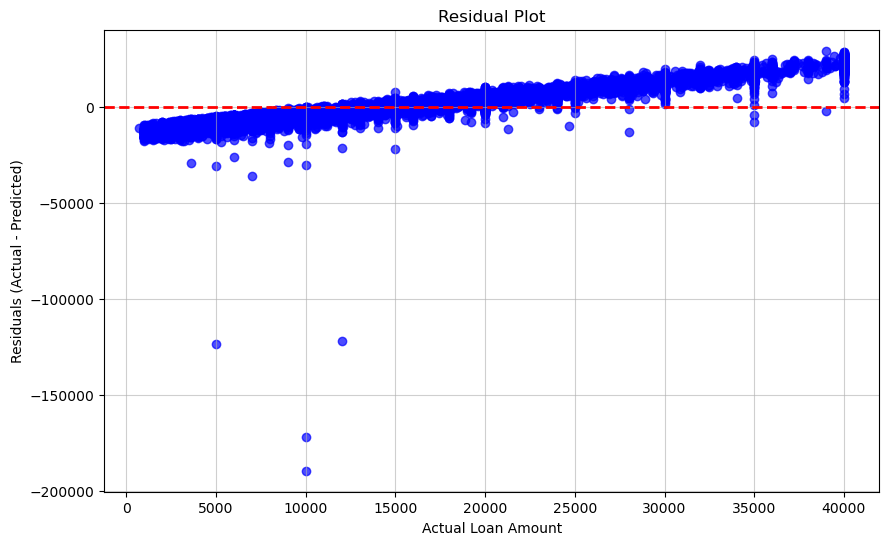

In [22]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred_scaled  # You can use any trained model, e.g., with scaling or additional features

# Create a residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Loan Amount')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(alpha=0.6)
plt.show()


## Explanation of Enhancements:
- Feature Scaling: This improves the numeric feature consistency and ensures features like annual_inc don't dominate the model.
- Residual Plot: This visualizes any systematic patterns in residuals and helps identify if the model fits the data well or has bias.